## Modified Slim

In [9]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt
import deepxde as dde


A = -0.155
eps = 0.32
kappa = 1.7
delta = 0.33

N1 = - (1 + np.arcsin(delta)) ** 2 / (eps * kappa ** 2)
N2 = (1 - np.arcsin(delta)) ** 2 / (eps * kappa ** 2)
N3 = - kappa / (eps * np.cos(np.arcsin(delta)) ** 2)

def gen_traindata(num):
    eps = 0.32
    kappa = 1.7
    delta = 0.33
    N = num
    center, eps, kappa, delta = np.array([[0.0,0.0]]), eps, kappa, delta
    tau = np.linspace(0, 2 * np.pi, N)
    # Define boundary of ellipse
    x_ellipse = np.asarray([1 + eps * np.cos(tau + np.arcsin(delta) * np.sin(tau)), 
                    eps * kappa * np.sin(tau)]).T
    xvals = x_ellipse
    uvals = np.zeros(len(xvals)).reshape(len(xvals), 1)
    return xvals, uvals


def pde_solovev(x, u):
    psi = u[:, 0:1]
    psi_r = dde.grad.jacobian(psi, x, i=0, j=0)
    psi_rr = dde.grad.hessian(psi, x, i=0, j=0)
    psi_zz = dde.grad.hessian(psi, x, i=1, j=1)
    GS = psi_rr - psi_r / x[:, 0:1] + psi_zz - (1 - A) * x[:, 0:1] ** 2 - A
    return GS

def psi_r(x,u):
    return dde.grad.jacobian(u, x, i=0, j=0)
def psi_z(x,u):
    return  dde.grad.jacobian(u, x, i=0, j=1)
def psi_rr(x, u):
    return dde.grad.hessian(u, x, i=0, j=0)
def psi_zz(x, u):
    return dde.grad.hessian(u, x, i=1, j=1)

def boundary_outer(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 + eps, 0]).all()
def boundary_inner(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 - eps, 0]).all()
def boundary_high(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 - delta * eps, kappa * eps]).all()

spatial_domain = dde.geometry.Ellipse(eps, kappa, delta) 

x,u = gen_traindata(1000)

n_test = 100
x_test,u_test = gen_traindata(n_test)
x_test = np.concatenate((x_test, spatial_domain.random_points(n_test)))
u_test = np.concatenate((u_test, np.zeros((n_test, 1))))

# specify psi, psi_r, psi_z, psi_rr, psi_zz at four locations 

observe_x = np.asarray([[1 + eps, 0], 
                        [1 - eps, 0], 
                        [1 - delta * eps, kappa * eps],
                        [1 - delta * eps, -kappa * eps]]
                    )
observe_y = np.asarray([0.0, 0.0, 0.0,0.0]).reshape(4, 1)

observe_x = np.concatenate((x,observe_x))
observe_y = np.concatenate((u,observe_y))

bc135 = dde.PointSetBC(x,u)
# bc135 = dde.PointSetBC(observe_x, observe_y)

# x[0] = R, x[1] = Z, u[0] = U
bc2 = dde.OperatorBC(spatial_domain ,
                    lambda x, u, _: psi_zz(x, u)+ N1*psi_r(x,u), 
                    boundary_outer)

bc4 = dde.OperatorBC(spatial_domain,
                    lambda x, u, _: psi_zz(x, u)+ N2*psi_r(x,u), 
                    boundary_inner)

bc6 = dde.OperatorBC(spatial_domain ,lambda x, u, _: psi_r(x, u), boundary_high)
bc7 = dde.OperatorBC(spatial_domain ,lambda x, u, _: psi_rr(x, u)+ N3 * psi_z(x, u), boundary_high)


data = dde.data.PDE(
    spatial_domain,
    pde_solovev,
    [bc135],
    #anchors=observe_x,
    num_domain=1024,
    num_boundary=0,
    x_test=x_test,
    y_test=u_test,
    train_distribution="LHS"
)

net = dde.maps.FNN([2] + 4 * [40] + [1], "tanh", "Glorot normal")

model = dde.Model(data, net)


Text(0, 0.5, '$u(r,z=0)$')

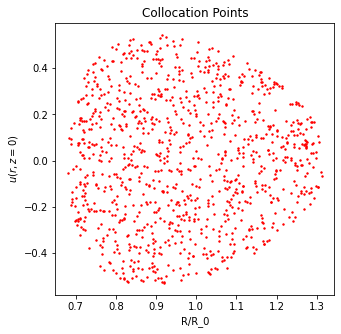

In [10]:
# Plot collocation points for visual check
fig,ax=plt.subplots(1, figsize=(5,5))
ax.scatter(data.train_x_all[:,0], data.train_x_all[:,1], s = 2, color='r')
ax.set_title('Collocation Points')
ax.set_xlabel('R/R_0')
ax.set_ylabel(r'$u(r,z=0)$')

In [11]:
from gs_solovev_sol import GS_Linear
# tokamak = GS_Linear(A=-0.155, eps= 2/6.2, kappa=1.6, delta=0.4)
ITER = GS_Linear(A=-0.155, eps= 0.32, kappa=1.7, delta=0.33)

## Train Model

Compiling model...
Building feed-forward neural network...
'build' took 0.566034 s

'compile' took 6.082195 s

Initializing variables...
Training model...

0         [1.68e+00, 3.18e+00]    [1.59e+00, 0.00e+00]    []  
100       [2.35e-01, 1.26e-01]    [3.21e-01, 0.00e+00]    []  
200       [1.81e-01, 7.08e-02]    [2.45e-01, 0.00e+00]    []  
300       [3.11e-02, 1.52e-01]    [5.98e-02, 0.00e+00]    []  
400       [1.61e-02, 2.46e-02]    [2.96e-02, 0.00e+00]    []  
500       [1.22e-02, 2.17e-03]    [2.15e-02, 0.00e+00]    []  
600       [2.28e-02, 2.13e-02]    [4.21e-02, 0.00e+00]    []  
700       [9.13e-03, 1.90e-03]    [1.61e-02, 0.00e+00]    []  
800       [4.41e-03, 8.43e-04]    [7.83e-03, 0.00e+00]    []  
900       [1.93e-03, 2.57e-04]    [3.72e-03, 0.00e+00]    []  
1000      [8.81e-04, 2.67e-04]    [1.92e-03, 0.00e+00]    []  
1100      [1.90e-03, 3.03e-04]    [3.80e-03, 0.00e+00]    []  
1200      [7.41e-04, 8.06e-05]    [1.64e-03, 0.00e+00]    []  
1300      [5.16e-04, 5.31

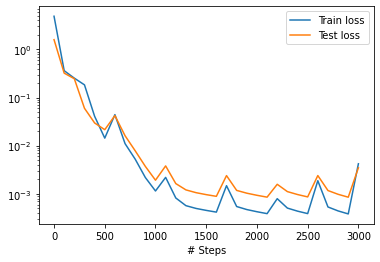

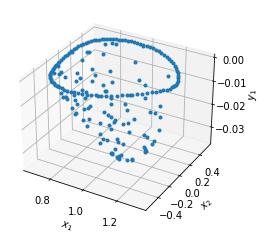

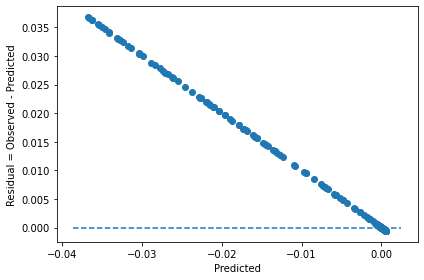

Compiling model...
'compile' took 4.789846 s

Training model...

Step      Train loss              Test loss               Test metric
3000      [2.32e-03, 1.90e-03]    [3.47e-03, 0.00e+00]    []  
3100      [6.62e-04, 2.75e-05]    [1.49e-03, 0.00e+00]    []  
3200      [5.27e-04, 1.20e-05]    [1.17e-03, 0.00e+00]    []  
3300      [4.44e-04, 1.37e-05]    [1.00e-03, 0.00e+00]    []  
3400      [3.81e-04, 1.52e-05]    [8.67e-04, 0.00e+00]    []  
3500      [3.31e-04, 1.56e-05]    [7.62e-04, 0.00e+00]    []  
3600      [2.96e-04, 1.53e-05]    [6.88e-04, 0.00e+00]    []  
3700      [2.67e-04, 1.47e-05]    [6.22e-04, 0.00e+00]    []  
3800      [2.48e-04, 1.35e-05]    [5.83e-04, 0.00e+00]    []  
3900      [2.28e-04, 1.29e-05]    [5.37e-04, 0.00e+00]    []  
4000      [2.14e-04, 1.25e-05]    [5.05e-04, 0.00e+00]    []  
4100      [1.98e-04, 1.15e-05]    [4.71e-04, 0.00e+00]    []  
4200      [1.88e-04, 1.95e-05]    [4.60e-04, 0.00e+00]    []  
4300      [1.75e-04, 1.04e-05]    [4.20e-04, 0

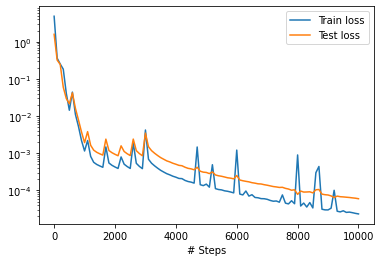

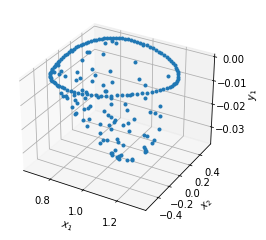

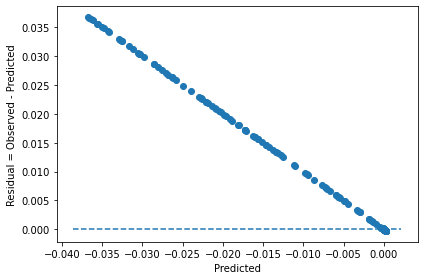

Accuracy
Mean residual: 0.024018615


In [12]:
import os
RUN_NAME = "run02"
PATH = f"./cefron/ITER/runs/{RUN_NAME}"
# Check whether the specified path exists or not
isExist = os.path.exists(PATH)
if not isExist:
  # Create a new directory because it does not exist 
  os.makedirs(PATH)
  print("The new directory is created!")

net = dde.maps.FNN([2] + 4 * [40] + [1], "tanh", "Glorot normal")

model = dde.Model(data, net)
# Compile, train and save model
model.compile(
    "adam", lr=5e-3,
    loss_weights=[1,100]
)

loss_history, train_state = model.train(epochs=3000, display_every = 100)
dde.saveplot(loss_history, train_state, issave=True, isplot=True,output_dir=f'./cefron/ITER/runs/{RUN_NAME}')

# Compile, train and save model
model.compile(
    "adam", lr=3e-4,
    loss_weights=[1,100]
)
loss_history, train_state = model.train(epochs=7000, display_every = 100, model_save_path=f"./cefron/ITER/runs/{RUN_NAME}/model/ITER-01.ckpt")
dde.saveplot(loss_history, train_state, issave=True, isplot=True,output_dir=f'./cefron/ITER/runs/{RUN_NAME}')


# make mesh
nx = 100
ny = 100
zoom = 0.05
x, y = np.meshgrid(
    np.linspace(1 - eps*(1+zoom), 1 + eps*(1+zoom), nx),
    np.linspace(-kappa * eps*(1+zoom), kappa * eps*(1+zoom), ny),
)
X = np.vstack((np.ravel(x), np.ravel(y))).T
output = model.predict(X)
GS = model.predict(X, operator=pde_solovev)
residual_psi = np.mean(np.absolute(GS))

print("Accuracy")
print("Mean residual:", residual_psi)

## Plotting

(500, 500)


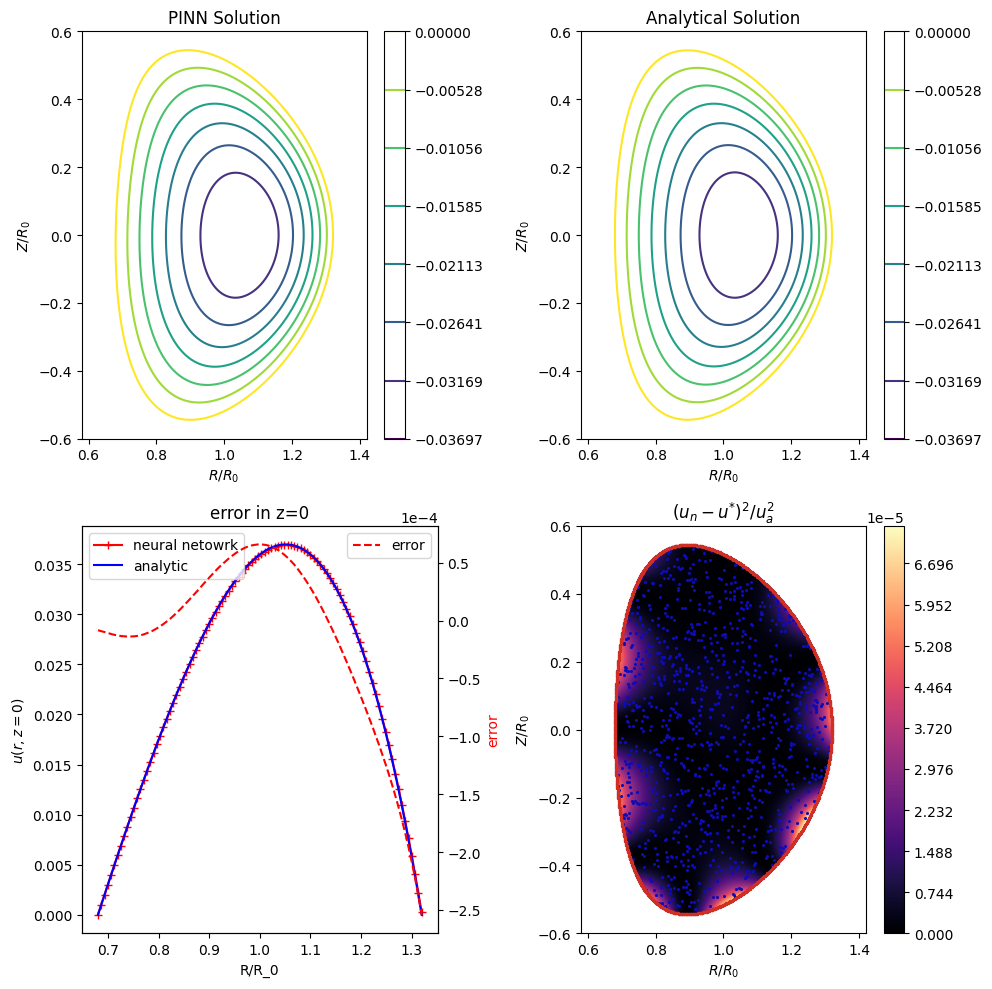

In [13]:
# Evaluation
from utils import evaluate,evaluate_eq, relative_error_plot
x,y,psi_pred,psi_true,error=evaluate(ITER,model)
x_eq, psi_true_eq, psi_pred_eq = evaluate_eq(ITER,model)

# Plotting Setup
plt.rcParams['figure.dpi'] = 100
print(psi_pred.shape)
fig,axs=plt.subplots(2,2,figsize=(10,10))
ax1,ax2,ax3,ax4=axs[0][0],axs[0][1],axs[1][0],axs[1][1]
levels = np.linspace(min(psi_true.reshape(-1)),0,8)

# Plot 1 - PINN Solution
cp = ax1.contour(x, y, psi_pred,levels=levels)
# ax1.scatter(observe_x[:,0], observe_x[:,1], s = 2,c="black")
fig.colorbar(cp,ax=ax1).formatter.set_powerlimits((0, 0)) 
ax1.set_title('PINN Solution')
ax1.set_xlabel(r'$R/R_{0}$')
ax1.set_ylabel(r'$Z/R_{0}$')
ax1.axis(xmin=0.58,xmax=1.42,ymin=-0.6, ymax=0.6)

# Plot 2 - Analytic Solution
cp = ax2.contour(x, y, psi_true,levels=levels)
fig.colorbar(cp,ax=ax2).formatter.set_powerlimits((0, 0))
ax2.set_title('Analytical Solution')
ax2.set_xlabel(r'$R/R_{0}$')
ax2.set_ylabel(r'$Z/R_{0}$')
ax2.axis(xmin=0.58,xmax=1.42,ymin=-0.6, ymax=0.6)

# Plot 3 - Equatorial Error
twin3 = ax3.twinx()
ax3.plot(x_eq, -psi_pred_eq,marker="+",color="red",label="neural netowrk")
ax3.plot(x_eq, -psi_true_eq,color="blue",label="analytic")
twin3.plot(x_eq, -(psi_true_eq-psi_pred_eq), color='red',linestyle='--',label="error")
twin3.yaxis.get_major_formatter().set_scientific(True)
ax3.set_title('error in z=0')
ax3.set_xlabel('R/R_0')
ax3.set_ylabel(r'$u(r,z=0)$')
ax3.legend(loc='upper left')
twin3.legend(loc='upper right')
twin3.set_ylabel('error', color='red')
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))

# Plot 4 - Relative Error
fig, ax4 = relative_error_plot(fig,ax4,x,y,error,model,ITER)
ax4.set_title(r'$(u_{n}-u^{*})^2/u_{a}^2$')
ax4.set_xlabel(r'$R/R_{0}$')
ax4.set_ylabel(r'$Z/R_{0}$')

fig.tight_layout()
plt.show()


